# This is a Guided Project. Analyzing Business Question Using SQL

## Read, Import and creating functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

# run_query function takes a SQL query as an argument and returns a pandas
# dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

# run_command function takes a SQL command as an argument and executes it
# using the sqlite module
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# show_tables function calls the run_query() function to return a list of 
# all tables and views in the database
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ('table','view')
        '''
    return run_query(q)

## A list of all tables in the database

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Tracks Sold in USA Analysis on Genre

In [15]:
q1 = '''
    WITH usa_tracks_sold AS
        (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        INNER JOIN customer c ON i.customer_id = c.customer_id
        WHERE c.country = "USA"
         )
         
    SELECT 
        g.name genre,
        COUNT(uts.invoice_line_id) tracks_sold,
        CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
            SELECT COUNT(invoice_line_id) FROM usa_tracks_sold) percentage_sold
    FROM usa_tracks_sold uts
    INNER JOIN track t ON t.track_id = uts.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
    '''
run_query(q1)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


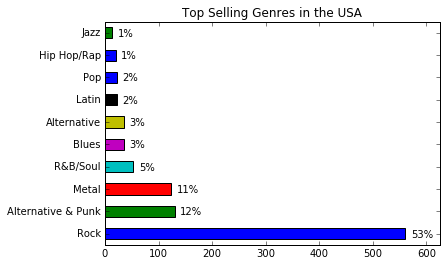

In [16]:
track_sold_plot = run_query(q1)
track_sold_plot.set_index('genre', inplace=True, drop=True)

track_sold_plot['tracks_sold'].plot.barh(
    title = 'Top Selling Genres in the USA',
    xlim = (0,625)
)

plt.ylabel('')
for i,label in enumerate(list(track_sold_plot.index)):
    score = track_sold_plot.loc[label, 'tracks_sold']
    label = (track_sold_plot.loc[label,'percentage_sold']*100)\
                .astype(int).astype(str)+'%'
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

  The most sold genre in the USA is Rock. None of these artists has genre in Rock. Punk is in the second place and Blues is in 5th place. 
  Artists:
      Red Tone
      Slim Jim Bites
      Meteor and the Girls
  are recommended for the store to buy.

## Sales Support Agent Analysis:

In [5]:
sales_per_agent = '''
    SELECT 
        e.first_name || ' ' || e.last_name sale_agent_name,
        SUM(i.total) total_sales,
        COUNT(i.invoice_id) number_of_sales,
        CAST(SUM(i.total) AS FLOAT)/COUNT(i.invoice_id) average_per_sale
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    INNER JOIN employee e ON e.employee_id = c.support_rep_id
    GROUP BY 1
    ORDER BY 2
    '''
run_query(sales_per_agent)

,sale_agent_name,total_sales,number_of_sales,average_per_sale
0,Steve Johnson,1393.92,188,7.414468
1,Margaret Park,1584.00,214,7.401869
2,Jane Peacock,1731.51,212,8.167500


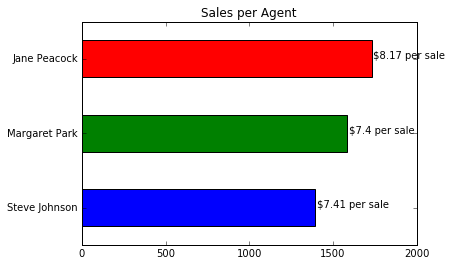

In [8]:
sales_per_agent_plot = run_query(sales_per_agent)
sales_per_agent_plot.set_index('sale_agent_name',inplace=True, drop=True)

sales_per_agent_plot['total_sales'].plot.barh(
    title = 'Sales per Agent',
    xlim = (0,2000))

plt.ylabel('')
for i, label in enumerate(list(sales_per_agent_plot.index)):
    total = sales_per_agent_plot.loc[label,'total_sales']
    label = '$'+(sales_per_agent_plot.loc[label,'average_per_sale'])\
                .astype(float).round(2).astype(str) + ' per sale'
    plt.annotate(str(label),(total + 10, i))
plt.show()

After this analysis, there are only three sales agent thats making sales.
Jane is the head in amoung these agents. 
However, Margaret has a higher total number of sale at 214 compare with 212 from Jane. This tells that Margaret is probably reaching out to more customer but have less sale skill than Jane.

## Customer Value Analysis with Other Country:

In [13]:
q_1 = '''
    CREATE VIEW country_customer_count AS
        SELECT 
            CASE
                WHEN (
                    SELECT COUNT(*)
                    FROM customer
                    WHERE country = c.country
                    ) = 1 THEN "Other"
                    ELSE c.country
                END AS country,
            c.customer_id,
            il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        '''
d = 'DROP VIEW IF EXISTS country_customer_count'
run_command(d)

run_command(q_1)
q_1t = "SELECT * FROM country_customer_count"
run_query(q_1t)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1
5,USA,18,6,1,1163,0.99,1
6,USA,18,7,1,1164,0.99,1
7,USA,18,8,1,1165,0.99,1
8,USA,18,9,1,1166,0.99,1
9,USA,18,10,1,1167,0.99,1


In [14]:
q_2 = '''
    SELECT
        country,
        total_number_of_customers,
        total_value_of_sales,
        value_sale_per_customer,
        avg_order_value
        FROM
            (
            SELECT
                country,
                COUNT(distinct customer_id) total_number_of_customers,
                SUM(unit_price) total_value_of_sales,
                CAST(SUM(unit_price) AS float)/COUNT(distinct customer_id) value_sale_per_customer,
                CAST(SUM(unit_price) AS float)/COUNT(distinct invoice_id) avg_order_value,
                CASE
                    WHEN country = 'Other' THEN 1
                    ELSE 0
                END AS sort
            FROM country_customer_count
            GROUP BY 1
            ORDER BY sort, 2 DESC
            )
        '''
run_query(q_2)

,country,total_number_of_customers,total_value_of_sales,value_sale_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


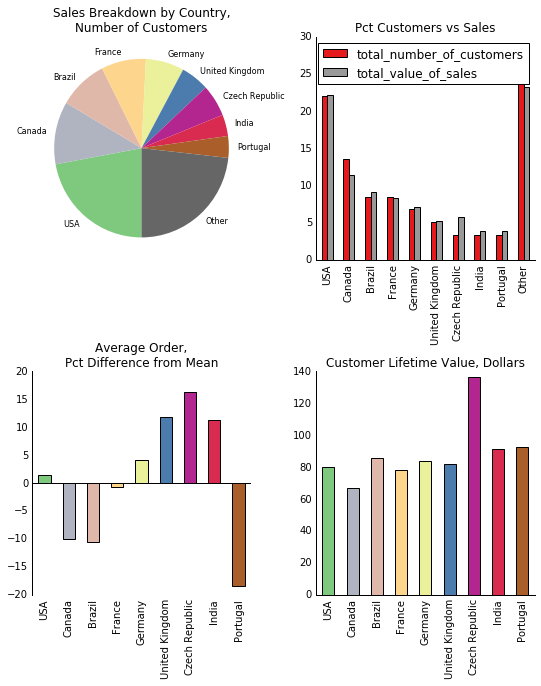

In [22]:
country_plot = run_query(q_2)
country_plot.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_plot.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_plot["total_value_of_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)


# top right
cvd_cols = ["total_number_of_customers","total_value_of_sales"]
custs_vs_dollars = country_plot[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_plot["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_plot["value_sale_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

USA and Canda has the highest total customer number. However, in bottom left plot, Canada has a low avg sale value. In the other hand, Germany, United Kingdom, Czech Republic and India have the higher average sale value. Czech Republic has the highest average customer sale value. 
Czech Republic may have potential for growth.

In [23]:

albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.